# Transformer Network

---
## 1. Exploring Positional Encoding in more detail

<font color='blue'><b>Key ideas:</b>
* Create positional encoding matrices to visualize the relational properties of the vectors
* Plot embeddings and positional encodings on a Cartesian plane to observe how they affect each other 

<font color='black'>
Positional encoding equations used before:

$$PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)$$
$$PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $k$ refers to each of the different dimensions in the positional encodings, with $i$ equal to $k$ $//$ $2$.

The meaning of these vectors can be difficult to grasp solely by examining the numerical representations, but visualizations can help give some intuition as to the semantic and positional similarity of the words. As we've seen in previous assignments, when embeddings are reduced to two dimensions and plotted, semantically similar words appear closer together, while dissimilar words are plotted farther apart. 

A similar exercise can be performed with positional encoding vectors - words that are closer in a sentence should appear closer when plotted on a Cartesian plane, and when farther in a sentence, should appear farther on the plane. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
def positional_encoding(positions, d, debug=False):
    """
    Precomputes a matrix with all the positional encodings 
    positions (int) -- Maximum number of positions to be encoded 
    d (int) -- Encoding size 
    pos_encoding -- (1, position, d)
    """
    
    p = np.arange(positions)[:, np.newaxis]   # (p, 1)
    i = np.arange(d)[np.newaxis, :] // 2      # (1, d)
    d = np.float32(d)                         # casting to float - just for caution

    angles = p / np.power(10000, 2*i/d)       # (p, d)
    angles[:, 0::2] = np.sin(angles[:, 0::2])
    angles[:, 1::2] = np.cos(angles[:, 1::2])
    
    pos_encoding = angles[np.newaxis, ...]    # (1, p, d)
    
    if debug:
        print(p.shape, '\n', p[:5,:])
        print(i.shape, '\n', i[:, :6])
        print(d)
        print(angles.shape)
        print(pos_encoding.shape, '\n', pos_encoding[:,:5,:])

    return tf.cast(pos_encoding, dtype=tf.float32)  # casting to float - just for caution

Define the embedding dimension as 100. **This value must match the dimensionality of the word embedding (because the two vectors - embedding & pos encoding are added together.)** In the ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) paper, embedding sizes range from 100 to 1024, depending on the task. The authors also use a maximum sequence length ranging from 40 to 512 depending on the task. Define the maximum sequence length to be 100, and the maximum number of words to be 64. 

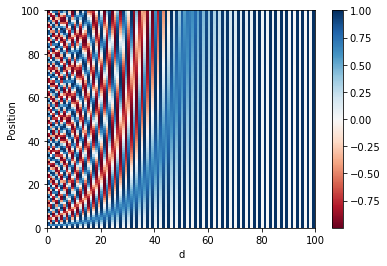

In [3]:
MAX_SEQUENCE_LENGTH = 100          # GloVe model used later embeds each word to 100 len vector
EMBEDDING_DIM       = 100

pos_encoding = positional_encoding(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, EMBEDDING_DIM))
plt.ylabel('Position')
plt.colorbar()
plt.show()


MAX_NB_WORDS = 64

Notice some interesting properties of the matrix - 
* **Property 1**: **L2 norm** of each of the vectors is always a constant. No matter what the value of `pos` is, the norm will always be the same value, which in this case is 7.071068. 
* The dot product of two positional encoding vectors is not affected by the scale of the vector, which has important implications for correlation calculations. (**as the scale, i.e. L2 norm will be the same in the denominator**)
* **Property 2**: Norm of the difference between 2 vectors separated by `k` positions is also constant. If you keep `k` constant and change `pos`, the difference will be of approximately the same value.

In [4]:
idx = 3
print(tf.norm(pos_encoding[0,idx,:]))

# L2 norm = sqrt(x1^2 + x2^2...)
tf.math.sqrt(tf.math.reduce_sum(pos_encoding[0,idx,:]**2))

tf.Tensor(7.071068, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=7.071068>

In [5]:
k = 13
idx1 = 25
idx2 = 47
print(tf.norm(pos_encoding[0,idx1,:] - pos_encoding[0,idx1+k,:]))
print(tf.norm(pos_encoding[0,idx2,:] - pos_encoding[0,idx2+k,:]))

tf.Tensor(5.8386927, shape=(), dtype=float32)
tf.Tensor(5.8386927, shape=(), dtype=float32)


### Comparing positional encodings

#### Correlation

The positional encoding matrix help to visualize how each vector is unique for every position. However, it is still not clear how these vectors can represent the relative position of the words in a sentence. To illustrate this, we will calculate the correlation between pairs of vectors at every single position. A successful positional encoder will produce a perfectly symmetric matrix in which maximum values are located at the main diagonal - vectors in similar positions should have the highest correlation. Following the same logic, the correlation values should get smaller as they move away from the main diagonal.

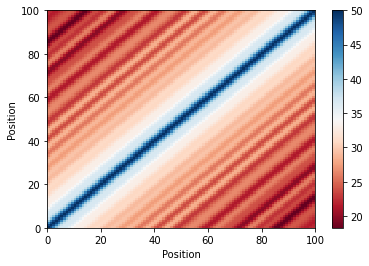

In [6]:
# Positional encoding correlation
corr = tf.matmul(pos_encoding, pos_encoding, transpose_b=True).numpy()[0]
plt.pcolormesh(corr, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Euclidean distance

We can also use the euclidean distance instead of the correlation for comparing the positional encoding vectors. In this case, our visualization will display a matrix in which the main diagonal is 0, and its off-diagonal values increase as they move away from the main diagonal.

(100, 100)


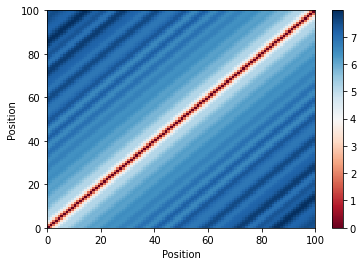

In [7]:
# Positional encoding euclidean distance
eu = np.zeros((MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH))
print(eu.shape)
for a in range(MAX_SEQUENCE_LENGTH):
    for b in range(a + 1, MAX_SEQUENCE_LENGTH):
        eu[a, b] = tf.norm(tf.math.subtract(pos_encoding[0, a], pos_encoding[0, b]))
        eu[b, a] = eu[a, b]
        
plt.pcolormesh(eu, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

---
## 2 - Semantic embedding

Let's gain a stronger intuition as to how positional encodings affect word embeddings by visualizing the sum of these vectors.

### Loading pretrained embeddings

**Note:** This embedding is composed of 400,000 words and each word embedding has 100 features.

In [8]:
embeddings_index = {}
GLOVE_DIR = "glove"
f = open('pretrainedmodel/nlp_glovevec/glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))
print('d_model: {}'.format(embeddings_index['hi'].shape))

Found 400000 word vectors.
d_model: (100,)


Each sentence is composed of sets of words, which have some semantic similarities among each groups.

In [9]:
texts = ['king queen man woman dog wolf football basketball red green yellow',
         'man queen yellow basketball green dog  woman football  king red wolf']

### Tokenizing & Embedding words

In [10]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS) #64
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')

data = pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)  #100

print(data.shape)
print(data)

Found 11 unique tokens
(2, 100)
[[ 1  2  3  4  5  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 3  2 11  8 10  5  4  7  1  9  6  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]


In [11]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    # words not found in embedding index will be all-zeros.
    if embeddings_index.get(word) is not None:
        embedding_matrix[i] = embeddings_index.get(word)
print(embedding_matrix.shape)

(12, 100)


In [12]:
word_index

{'king': 1,
 'queen': 2,
 'man': 3,
 'woman': 4,
 'dog': 5,
 'wolf': 6,
 'football': 7,
 'basketball': 8,
 'red': 9,
 'green': 10,
 'yellow': 11}

In [13]:
# 'King' into 100 len vector
embedding_matrix[1,:].round(2)

array([-0.32, -0.88,  0.22,  0.25,  0.23,  0.74, -0.38, -0.35, -0.84,
       -1.11, -0.3 ,  0.33, -0.25,  0.3 , -0.08, -0.9 ,  0.09, -1.14,
       -0.58,  0.67, -0.23, -0.96,  0.28, -0.08,  0.75,  0.27,  0.34,
       -0.34,  0.96,  0.07,  0.46,  0.4 ,  0.58,  0.39, -0.22,  0.59,
       -0.56,  0.63, -0.04, -0.69, -0.38,  0.38,  0.62, -0.88, -0.12,
       -0.38, -0.38,  0.24,  0.67, -0.43, -0.11,  0.08,  1.16,  0.79,
       -0.21, -2.32, -0.68,  0.45,  0.66,  0.1 ,  0.46,  0.2 ,  0.26,
        0.06,  0.53, -0.43, -0.34,  0.6 , -0.58,  0.07,  0.24, -0.85,
        0.3 , -0.34, -0.26, -0.03, -0.16,  0.45, -0.92,  0.65,  0.73,
       -0.23,  0.3 ,  0.04, -0.84,  0.55, -0.53, -1.74,  0.48, -0.7 ,
        0.06, -0.71,  0.09,  0.41, -1.34, -0.62, -0.33, -0.53,  0.16,
       -0.99])

Create an embedding layer using the weights extracted from the pretrained glove embeddings.

In [14]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,  # 100
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            trainable=False)

In [15]:
embedding = embedding_layer(data)
print(embedding.shape)

(2, 100, 100)


In [16]:
# King in sentence 1
embedding[0,0,:].numpy().round(2)

array([-0.32, -0.88,  0.22,  0.25,  0.23,  0.74, -0.38, -0.35, -0.84,
       -1.11, -0.3 ,  0.33, -0.25,  0.3 , -0.08, -0.9 ,  0.09, -1.14,
       -0.58,  0.67, -0.23, -0.96,  0.28, -0.08,  0.75,  0.27,  0.34,
       -0.34,  0.96,  0.07,  0.46,  0.4 ,  0.58,  0.39, -0.22,  0.59,
       -0.56,  0.63, -0.04, -0.69, -0.38,  0.38,  0.62, -0.88, -0.12,
       -0.38, -0.38,  0.24,  0.67, -0.43, -0.11,  0.08,  1.16,  0.79,
       -0.21, -2.32, -0.68,  0.45,  0.66,  0.1 ,  0.46,  0.2 ,  0.26,
        0.06,  0.53, -0.43, -0.34,  0.6 , -0.58,  0.07,  0.24, -0.85,
        0.3 , -0.34, -0.26, -0.03, -0.16,  0.45, -0.92,  0.65,  0.73,
       -0.23,  0.3 ,  0.04, -0.84,  0.55, -0.53, -1.74,  0.48, -0.7 ,
        0.06, -0.71,  0.09,  0.41, -1.34, -0.62, -0.33, -0.53,  0.16,
       -0.99], dtype=float32)

In [17]:
# King in sentence 2
embedding[1,8,:].numpy().round(2)

array([-0.32, -0.88,  0.22,  0.25,  0.23,  0.74, -0.38, -0.35, -0.84,
       -1.11, -0.3 ,  0.33, -0.25,  0.3 , -0.08, -0.9 ,  0.09, -1.14,
       -0.58,  0.67, -0.23, -0.96,  0.28, -0.08,  0.75,  0.27,  0.34,
       -0.34,  0.96,  0.07,  0.46,  0.4 ,  0.58,  0.39, -0.22,  0.59,
       -0.56,  0.63, -0.04, -0.69, -0.38,  0.38,  0.62, -0.88, -0.12,
       -0.38, -0.38,  0.24,  0.67, -0.43, -0.11,  0.08,  1.16,  0.79,
       -0.21, -2.32, -0.68,  0.45,  0.66,  0.1 ,  0.46,  0.2 ,  0.26,
        0.06,  0.53, -0.43, -0.34,  0.6 , -0.58,  0.07,  0.24, -0.85,
        0.3 , -0.34, -0.26, -0.03, -0.16,  0.45, -0.92,  0.65,  0.73,
       -0.23,  0.3 ,  0.04, -0.84,  0.55, -0.53, -1.74,  0.48, -0.7 ,
        0.06, -0.71,  0.09,  0.41, -1.34, -0.62, -0.33, -0.53,  0.16,
       -0.99], dtype=float32)

In [18]:
# both vectors are same
embedding[0,0,:].numpy().round(2) - embedding[1,8,:].numpy().round(2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### Visualization on a Cartesian plane
We will use PCA to reduce the 100 features of the glove embedding to only 2 components.

In [19]:
sequences

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [3, 2, 11, 8, 10, 5, 4, 7, 1, 9, 6]]

In [20]:
from sklearn.decomposition import PCA

def plot_words(embedding, sequences, idx):
    pca = PCA(n_components=2)
    X_pca_train = pca.fit_transform(embedding[idx,0:len(sequences[idx]),:])
    
    fig, ax = plt.subplots(figsize=(8, 4)) 
    plt.rcParams['font.size'] = '12'
    ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1])
    words = list(word_index.keys())
    for i, index in enumerate(sequences[idx]):
        ax.annotate(words[index-1], (X_pca_train[i, 0], X_pca_train[i, 1]))


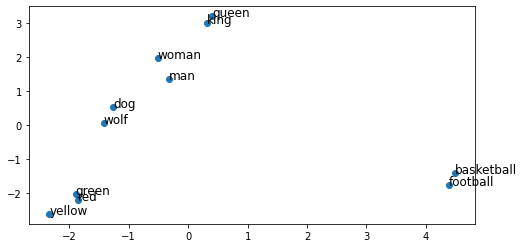

In [21]:
plot_words(embedding, sequences, 0)

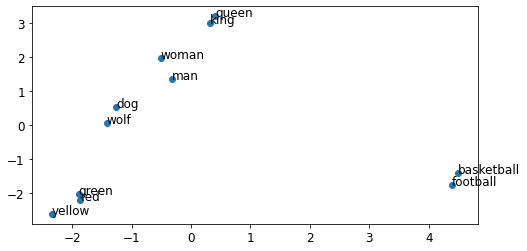

In [22]:
plot_words(embedding, sequences, 1)

**Notice: how similar words are bunched together (dog, wolf) , (green, red, yellow), (football, basketball) etc.**

## 3 - Semantic and positional embedding

Next, we will combine the original GloVe embedding with the positional encoding calculated earlier, **using a 1-to-1 ratio**. 

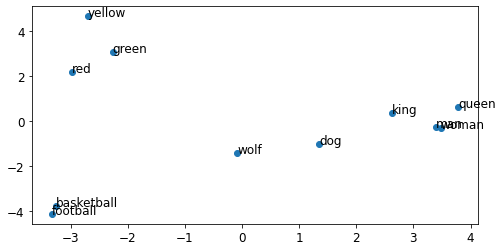

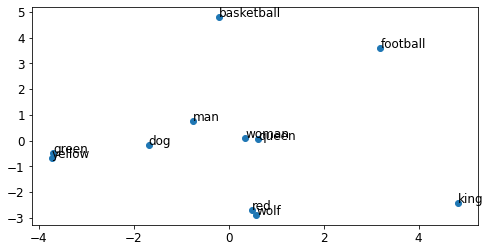

In [23]:
embedding2 = embedding * 1.0 + pos_encoding[:,:,:] * 1.0

plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)

**Notice: some dis-similar words are also grouped together, such as (red, wolf)**

Trying different weighing schemes:

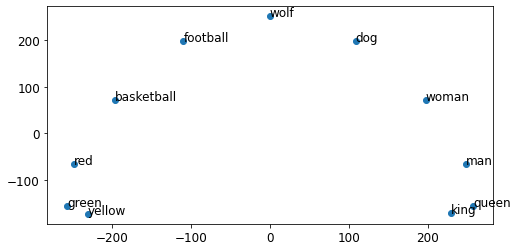

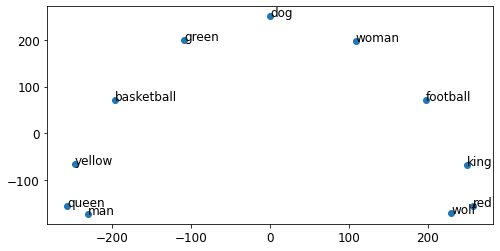

In [24]:
W1 = 1 
W2 = 100   # positional embedding will Dominate
embedding2 = embedding * W1 + pos_encoding[:,:,:] * W2
plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)

# For reference
#['king queen man woman dog wolf football basketball red green yellow',
# 'man queen yellow basketball green dog  woman football  king red wolf']

In the previous Transformer notebook, the word embedding is multiplied by `sqrt(EMBEDDING_DIM)`. In this case, it will be equivalent using `W1 = sqrt(EMBEDDING_DIM) = 10` and `W2 = 1`. 